# **Deteksi Komentar Cyberbullying di Twitter Menggunakan IndoBERT**

## **Business Understanding**

Perkembangan pesat media sosial seperti Twitter telah memberikan ruang bagi masyarakat untuk berkomunikasi secara luas dan terbuka. Namun, di balik kemudahan ini, muncul pula berbagai permasalahan, salah satunya adalah maraknya komentar yang mengandung unsur cyberbullying. Cyberbullying merupakan tindakan penindasan atau perundungan yang dilakukan melalui media digital, yang dapat memberikan dampak negatif secara psikologis kepada korbannya. Oleh karena itu, diperlukan sebuah sistem yang mampu mendeteksi komentar berbau cyberbullying secara otomatis agar tindakan preventif dapat segera dilakukan.

Proyek ini bertujuan untuk mengembangkan sebuah model klasifikasi teks berbasis pembelajaran mesin, khususnya menggunakan model IndoBERT, untuk mendeteksi komentar cyberbullying dalam bahasa Indonesia pada platform Twitter. Dengan memanfaatkan kemampuan pemahaman bahasa alami dari model IndoBERT, sistem ini diharapkan dapat mengidentifikasi komentar yang bersifat merugikan dengan tingkat akurasi yang tinggi. Proyek ini tidak hanya bermanfaat dalam ranah akademik sebagai penerapan Natural Language Processing (NLP), tetapi juga memiliki potensi penerapan nyata dalam meningkatkan keamanan dan kenyamanan pengguna di platform digital.

## **Data Understanding**

### **Data Exploration**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

In [2]:
# df = pd.read_csv('data/raw/dataset.csv')
df = pd.read_excel('DATASET_CYBERBULLYING_TWITTER.xlsx')
df.head()

,No.,Nama Pelaku,Komentar,Kategori,Tanggal Posting,Nama Korban,Unnamed: 6,Unnamed: 7
0,1,@khanayarudinita,"""Makin jelek aja anaknya, padahal ibu ayahnya ...",Bullying,22 Juni 2019,@tasyakamila,NaN,NaN
1,2,@frdtias_,"""Jijik astagah sok bat cakep njs""",Bullying,28 Maret 2020,@eeericko,NaN,NaN
2,3,@belumadajudullagi,"""Kaya tulus ya mukanya klo diliat2""",Non-bullying,7 Maret 2021,@jeromepolin,NaN,NaN
3,4,@teukualmunawir,"""Jadi diri sendiri, jangan jadi ular apalagi d...",Bullying,18 Desember 2020,@rosameldianti_,NaN,NaN
4,5,@biankarachel,"""Aduuh.. terlalu halu.. hhahaha lebay editan n...",Bullying,7 Desember 2020,@rosameldianti_,NaN,NaN


In [3]:
df = df[['Komentar', 'Kategori']]
df.columns = ['tweet', 'label']
df.head()

,tweet,label
0,"""Makin jelek aja anaknya, padahal ibu ayahnya ...",Bullying
1,"""Jijik astagah sok bat cakep njs""",Bullying
2,"""Kaya tulus ya mukanya klo diliat2""",Non-bullying
3,"""Jadi diri sendiri, jangan jadi ular apalagi d...",Bullying
4,"""Aduuh.. terlalu halu.. hhahaha lebay editan n...",Bullying


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   650 non-null    object
 1   label   650 non-null    object
dtypes: object(2)
memory usage: 10.3+ KB


<ipython-input-5-2322096733>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


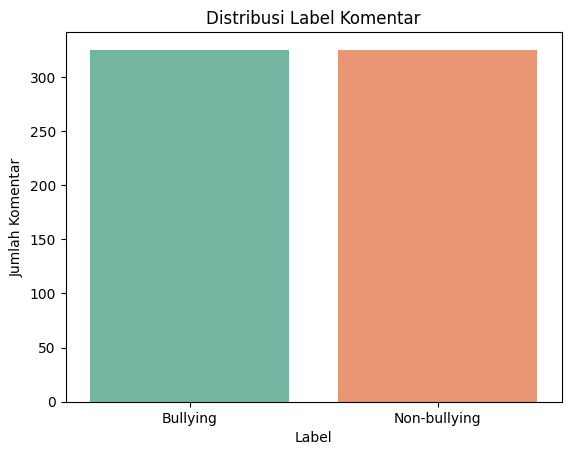

In [5]:
df['label'].value_counts()

sns.countplot(x='label', data=df, palette='Set2')
plt.title("Distribusi Label Komentar")
plt.xlabel("Label")
plt.ylabel("Jumlah Komentar")
plt.show()

In [6]:
df['text_length_char'] = df['tweet'].apply(len)
df['text_length_word'] = df['tweet'].apply(lambda x: len(x.split()))

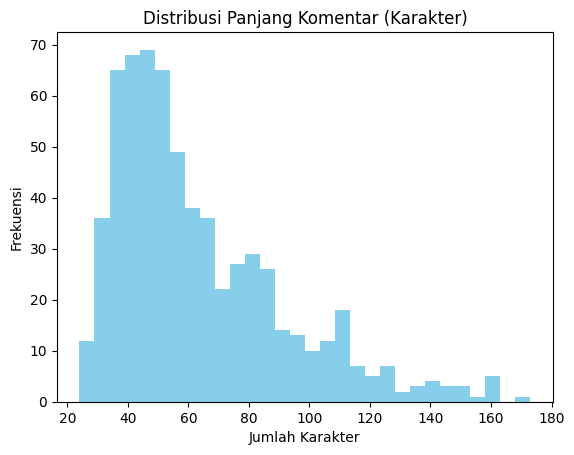

In [7]:
plt.hist(df['text_length_char'], bins=30, color='skyblue')
plt.title("Distribusi Panjang Komentar (Karakter)")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")
plt.show()

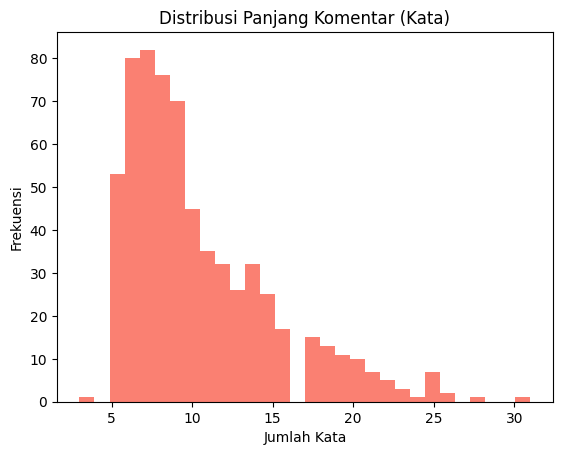

In [8]:
plt.hist(df['text_length_word'], bins=30, color='salmon')
plt.title("Distribusi Panjang Komentar (Kata)")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|[^a-z\s]", '', text)
    return text

df['clean_tweet'] = df['tweet'].apply(clean_text)

cyberbullying_text = " ".join(df[df['label'] == 'Bullying']['clean_tweet'])
non_cyberbullying_text = " ".join(df[df['label'] == 'Non-bullying']['clean_tweet'])

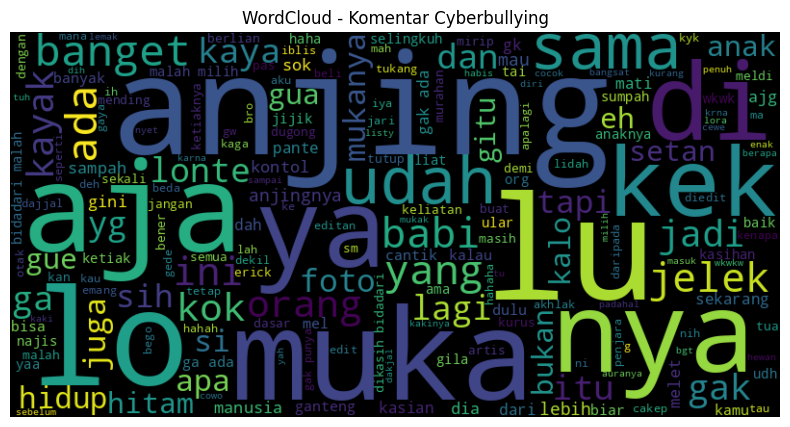

In [10]:
wordcloud_cyber = WordCloud(width=800, height=400).generate(cyberbullying_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_cyber, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Komentar Cyberbullying")
plt.show()

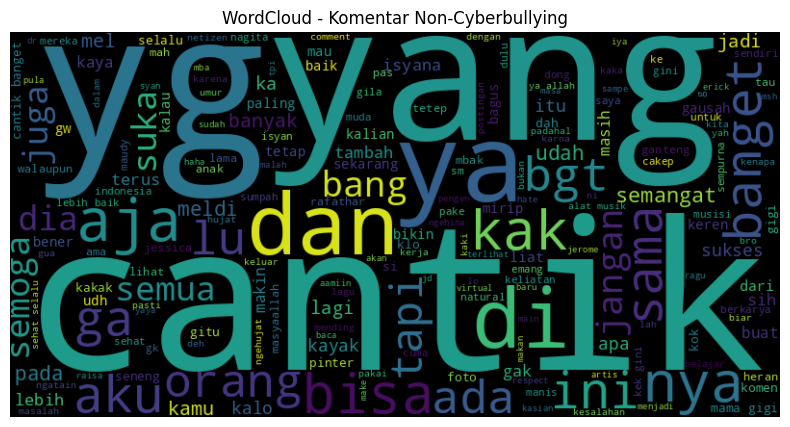

In [11]:
wordcloud_non = WordCloud(width=800, height=400).generate(non_cyberbullying_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Komentar Non-Cyberbullying")
plt.show()

In [12]:
for label in df['label'].unique():
    print(f"\nContoh komentar - {label.upper()}")
    print(df[df['label'] == label]['tweet'].sample(3, random_state=42).to_string(index=False))


Contoh komentar - BULLYING
          "atas bawah hitam putih, kek kopi luwak"
"Ni org jelek ga ada obat.kok jj mau liat apa y...
"Gini dong bersihan kaga kek tahun tahun sebelu...

Contoh komentar - NON-BULLYING
"Sukaa bnget sm artis ini… nggak neko2.. dan na...
               "Yang satu nya mirip Ariana grande"
"@xrickolim smngat trus bro tiada manusia yg se...


## **Data Preparation**

### **Data Preprocessing**

In [13]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import os

In [14]:
slang_dict = {
    "aja": "saja",
    "ajaib": "aneh",
    "anjay": "wow",
    "anjing": "kasar",
    "babi": "kasar",
    "baper": "tersinggung",
    "bgt": "banget",
    "blm": "belum",
    "bnyk": "banyak",
    "btw": "ngomong-ngomong",
    "cantik": "menarik",
    "cie": "cie",
    "ciee": "cie",
    "cm": "cuma",
    "cmn": "cuma",
    "dah": "sudah",
    "dmn": "dimana",
    "doang": "saja",
    "dr": "dari",
    "dtg": "datang",
    "elo": "kamu",
    "ga": "tidak",
    "gabut": "bosan",
    "gaje": "tidak jelas",
    "gak": "tidak",
    "gini": "begini",
    "gpp": "tidak apa-apa",
    "gt": "gitu",
    "hrus": "harus",
    "jd": "jadi",
    "jelek": "buruk",
    "jg": "juga",
    "kalo": "kalau",
    "kaya": "seperti",
    "kayak": "seperti",
    "kek": "seperti",
    "kepo": "penasaran",
    "knp": "kenapa",
    "kok": "mengapa",
    "krn": "karena",
    "lo": "kamu",
    "loe": "kamu",
    "lol": "lucu",
    "lu": "kamu",
    "makasi": "terima kasih",
    "makasih": "terima kasih",
    "malah": "justru",
    "mknya": "makanya",
    "ngerti": "paham",
    "ngga": "tidak",
    "nolep": "penyendiri",
    "pdhl": "padahal",
    "sama2": "sama-sama",
    "sih": "",
    "sm": "sama",
    "thx": "terima kasih",
    "tp": "tapi",
    "tq": "terima kasih",
    "trs": "terus",
    "udah": "sudah",
    "wkwk": "haha",
    "wkwkwk": "haha",
    "yg": "yang"
}

def normalize_slang(text):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return " ".join(normalized_words)

def clean_text(text):
    text = text.lower()                            # Ubah ke huruf kecil
    text = re.sub(r"http\S+|www.\S+", "", text)    # Hapus URL
    text = re.sub(r"@\w+|#\w+", "", text)          # Hapus mention dan hashtag
    text = re.sub(r"[^a-zA-Z\s]", "", text)        # Hapus karakter non-alfabet
    text = re.sub(r'(.)\1+', r'\1', text)          # Hapus karakter berulang (cth: ciee -> cie)
    text = re.sub(r"\s+", " ", text).strip()       # Hapus spasi berlebih
    text = normalize_slang(text)                   # Normalisasi slang
    return text

df['clean_tweet'] = df['tweet'].apply(clean_text)
df['clean_tweet'].head()

,clean_tweet
0,makin buruk saja anaknya padahal ibu ayahnya c...
1,jijik astagah sok bat cakep njs
2,seperti tulus ya mukanya klo diliat
3,jadi diri sendiri jangan jadi ular apalagi dugong
4,aduh terlalu halu hahaha lebay editan nya lema...


In [15]:
df['label_encoded'] = df['label'].map({'Non-bullying': 0, 'Bullying': 1})
df.head()

,tweet,label,text_length_char,text_length_word,clean_tweet,label_encoded
0,"""Makin jelek aja anaknya, padahal ibu ayahnya ...",Bullying,53,8,makin buruk saja anaknya padahal ibu ayahnya c...,1
1,"""Jijik astagah sok bat cakep njs""",Bullying,33,6,jijik astagah sok bat cakep njs,1
2,"""Kaya tulus ya mukanya klo diliat2""",Non-bullying,35,6,seperti tulus ya mukanya klo diliat,0
3,"""Jadi diri sendiri, jangan jadi ular apalagi d...",Bullying,52,8,jadi diri sendiri jangan jadi ular apalagi dugong,1
4,"""Aduuh.. terlalu halu.. hhahaha lebay editan n...",Bullying,99,13,aduh terlalu halu hahaha lebay editan nya lema...,1


In [16]:
df = df[['clean_tweet', 'label_encoded']]
df.head()

,clean_tweet,label_encoded
0,makin buruk saja anaknya padahal ibu ayahnya c...,1
1,jijik astagah sok bat cakep njs,1
2,seperti tulus ya mukanya klo diliat,0
3,jadi diri sendiri jangan jadi ular apalagi dugong,1
4,aduh terlalu halu hahaha lebay editan nya lema...,1


In [17]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_tweet'],
    df['label_encoded'],
    test_size=0.2,
    stratify=df['label_encoded'],
    random_state=42
)

# 📌 Gabungkan kembali ke dataframe
train_df = pd.DataFrame({'tweet': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'tweet': test_texts, 'label': test_labels})

# # 📌 Simpan dataset hasil preprocessing
# os.makedirs('data/processed', exist_ok=True)
# train_df.to_csv('data/processed/train.csv', index=False)
# test_df.to_csv('data/processed/test.csv', index=False)

## **Modeling**

In [18]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

In [19]:
# train_df = pd.read_csv('data/processed/train.csv')
# test_df = pd.read_csv('data/processed/test.csv')

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

def tokenize_function(example):
    return tokenizer(example["tweet"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    # output_dir="./model/indobert-cyberbullying",
    output_dir="./model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/520 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-19-525167642>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 2210631170104 (cintarenita-universitas-singaperbangsa-karawang) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.548400,0.522940,0.753846,0.689655,0.923077,0.789474
2,0.116400,0.607412,0.815385,0.759494,0.923077,0.833333
3,0.028900,0.512444,0.861538,0.850746,0.876923,0.863636
4,0.002900,0.576276,0.861538,0.850746,0.876923,0.863636


TrainOutput(global_step=132, training_loss=0.1957809601621138, metrics={'train_runtime': 108.5457, 'train_samples_per_second': 19.162, 'train_steps_per_second': 1.216, 'total_flos': 136817748787200.0, 'train_loss': 0.1957809601621138, 'epoch': 4.0})

In [20]:
trainer.save_model("./model_save")
tokenizer.save_pretrained("/model_save")
# trainer.save_model("./model/indobert-cyberbullying")
# tokenizer.save_pretrained("./model/indobert-cyberbullying")

# print("Model IndoBERT selesai dilatih dan disimpan.")

('/model_save/tokenizer_config.json',
 '/model_save/special_tokens_map.json',
 '/model_save/vocab.txt',
 '/model_save/added_tokens.json',
 '/model_save/tokenizer.json')

## **Evaluation**

In [21]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [25]:
tokenizer = AutoTokenizer.from_pretrained('./model_save')
model = AutoModelForSequenceClassification.from_pretrained('./model_save')

inputs = tokenizer(list(test_df['tweet']), padding=True, truncation=True, max_length=128, return_tensors="pt")

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1).numpy()

labels = test_df['label'].values

report = classification_report(labels, predictions, target_names=['Non-bullying', 'Bullying'])
print(report)

# with open("evaluation/evaluation_report.txt", "w") as f:
#     f.write(report)

              precision    recall  f1-score   support

Non-bullying       0.87      0.85      0.86        65
    Bullying       0.85      0.88      0.86        65

    accuracy                           0.86       130
   macro avg       0.86      0.86      0.86       130
weighted avg       0.86      0.86      0.86       130



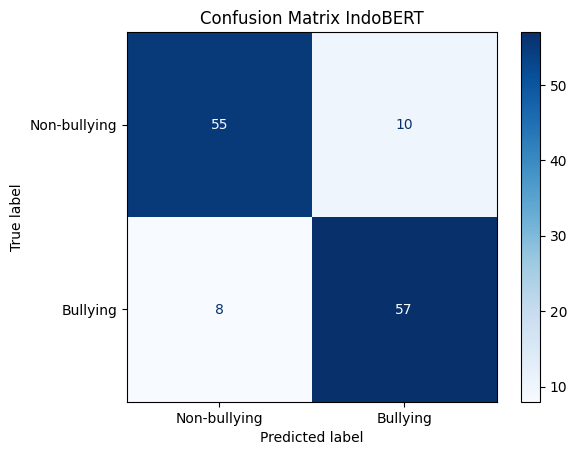

In [26]:
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-bullying', 'Bullying'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix IndoBERT")
plt.show()